In [1]:
from __future__ import print_function
import numpy as np
import time
import math
#import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import csv
import os
from PIL import Image
from scipy.misc import imsave

In [ ]:
# convert .mat file to .csv file
# use code from https://github.com/prijip/Py-Gsvhn-DigitStruct-Reader 
# to get python file that converts .mat to .csv file
# copy the directory downloaded in the current folder

# run this code to create digitStruct.csv in their respective directories
# RUN ONLY ONCE
#%run ./Py-Gsvhn-DigitStruct-Reader/digitStructMatToCsv.py ./train/digitStruct.mat ./train/digitStruct.csv
#%run ./Py-Gsvhn-DigitStruct-Reader/digitStructMatToCsv.py ./test/digitStruct.mat ./test/digitStruct.csv
#%run ./Py-Gsvhn-DigitStruct-Reader/digitStructMatToCsv.py ./extra/digitStruct.mat ./extra/digitStruct.csv

In [2]:
# convert digitStruct.csv to a dictionary for easier use
def make_dict(dir_name):
    filename = 'digitStruct.csv'
    fullpath = os.path.join(dir_name, filename)
    f=open(fullpath,'rb')

    reader=csv.reader(f)
    counter=0
    mystruct={}
    for row in reader:
        if counter==0:
            #print header
            #print (row)
            counter=counter+1
            continue
        else:
            #
            if row[0] in mystruct.keys():
                tmp=mystruct[row[0]]
                if row[1]=='10':
                    row[1]='0'
                label=tmp['label']
                label.append(int(row[1]))
                tmp['label']=label
                tmp['len_label']=len(label)
                tmp['left']=min(tmp['left'],int(row[2]))
                tmp['top']=min(tmp['top'],int(row[3]))
                tmp['right']=max(tmp['right'],int(row[2])+int(row[4]))
                tmp['bottom']=max(tmp['bottom'],int(row[3])+int(row[5]))
            else:
                temp={}
                temp['name']=row[0]
                if row[1]=='10':
                    row[1]='0'
                label=[]
                label.append(int(row[1]))
                temp['label']=label
                temp['len_label']=len(label)
                temp['left']=int(row[2])
                temp['top']=int(row[3])
                temp['width']=int(row[4])
                temp['height']=int(row[5])
                temp['bottom']=int(row[3])+int(row[5])
                temp['right']=int(row[2])+int(row[4])
                mystruct[row[0]]=temp

    #close file    
    f.close()

    return mystruct


In [3]:
# create dictionary from train: digitStruct.csv file
train_dir='train'
train_dict = make_dict(train_dir)

In [4]:
# DEBUG CODE: can be ignored
mykeys = train_dict.keys()
min_len = 0
max_len = 0
for idx in range(len(mykeys)):
    k=mykeys[idx]
    tmpdict=train_dict[k]
    #print(tmpdict)

    filename=tmpdict['name']
    label_list=tmpdict['label']
    if len(label_list)>5:
        print(tmpdict)
    if len(label_list)<min_len:
        min_len = len(label_list)
    if len(label_list)>max_len:
        max_len = len(label_list)
print('min: %d, max: %d'%(min_len, max_len))

{'right': 64, 'name': '29930.png', 'bottom': 22, 'top': 3, 'label': [1, 3, 5, 4, 5, 8], 'height': 18, 'width': 5, 'len_label': 6, 'left': 18}
min: 0, max: 6


In [5]:
# create dictionary from test: digitStruct.csv file
test_dir='test'
test_dict = make_dict(test_dir)
# create dictionary from extra: digitStruct.csv file
extra_dir='extra'
extra_dict = make_dict(extra_dir)

In [6]:
# print length of dictionaries to get counts of images in train, test and extra folders
print(len(train_dict.keys()))
print(len(test_dict.keys()))
print(len(extra_dict.keys()))

33402
13068
202353


In [7]:
# define a function that calculates minimum and maximum length of sequence in images from the images dictionary
def get_min_max_len(my_dict):
    mykeys = my_dict.keys()
    min_len = 0
    max_len = 0
    for idx in range(len(mykeys)):
        k=mykeys[idx]
        tmpdict=my_dict[k]
        #print(tmpdict)

        filename=tmpdict['name']
        label_list=tmpdict['label']
        if len(label_list)<min_len:
            min_len = len(label_list)
        if len(label_list)>max_len:
            max_len = len(label_list)
    #print('min: %d, max: %d'%(min_len, max_len)) 
    return min_len, max_len


In [8]:
train_min_len, train_max_len = get_min_max_len(train_dict)
test_min_len,  test_max_len  = get_min_max_len(test_dict)
extra_min_len, extra_max_len = get_min_max_len(extra_dict)
print('train min: %d, train max: %d'%(train_min_len, train_max_len)) 
print('test min: %d,  test max: %d'%(test_min_len, test_max_len)) 
print('extra min: %d, extra max: %d'%(extra_min_len, extra_max_len)) 

train min: 0, train max: 6
test min: 0,  test max: 5
extra min: 0, extra max: 5


In [9]:
# DEBUG CODE: can be ignored
extra_dict['34797.png']

{'bottom': 64,
 'height': 50,
 'label': [5, 7, 5],
 'left': 20,
 'len_label': 3,
 'name': '34797.png',
 'right': 80,
 'top': 8,
 'width': 23}

In [10]:
# define a function that calculates length/digit frequencies in the images dictionary
def get_frequencies(my_dict, max_l, return_max_arr=False):
    mykeys = my_dict.keys()
    freqs_l = np.zeros([max_l+1], dtype=int)#frequencies of length
    freqs_d = np.zeros([10], dtype=int)#frequencies of digits
    max_arr = []
    for idx in range(len(mykeys)):
        k=mykeys[idx]
        tmpdict=my_dict[k]
        #print(tmpdict)

        filename=tmpdict['name']
        label_list=tmpdict['label']
        length=len(label_list)
        freqs_l[length]=freqs_l[length]+1
        
        for jdx in range(length):
            digit=label_list[jdx]
            freqs_d[digit]=freqs_d[digit]+1
        if return_max_arr == True and length == max_l:
            max_arr.append(k)
    
    return freqs_l, freqs_d, max_arr

tr_freqs_l, tr_freqs_d, tr_outliers = get_frequencies(train_dict,train_max_len, True)
te_freqs_l, te_freqs_d, te_outliers = get_frequencies(test_dict, test_max_len)
ex_freqs_l, ex_freqs_d, ex_outliers = get_frequencies(extra_dict, extra_max_len)

In [11]:
# print the frequencies for length/characters and outliers for train data(train_max_len = 6)
print(tr_freqs_l) 
print(tr_freqs_d)
print(tr_outliers)
print(te_freqs_l)
print(te_freqs_d)
print(te_outliers)
print(ex_freqs_l)
print(ex_freqs_d)
print(ex_outliers)

[    0  5137 18130  8691  1434     9     1]
[ 4948 13861 10585  8497  7458  6882  5727  5595  5045  4659]
['29930.png']
[   0 2483 8356 2081  146    2]
[1744 5099 4149 2882 2523 2384 1977 2019 1660 1595]
[]
[     0   9385  71726 106789  14338    115]
[45550 90560 74740 60765 50633 53490 41582 43997 35358 34456]
[]


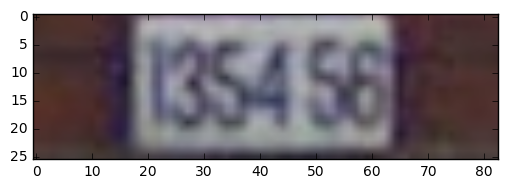

In [12]:
# print outlier (image with 6 characters)
outlier=tr_outliers[0]
fpath=os.path.join('train', outlier)
my_img=Image.open(fpath)

import matplotlib.pyplot as plt
%matplotlib inline
imgplot=plt.imshow(my_img,cmap='Greys_r')

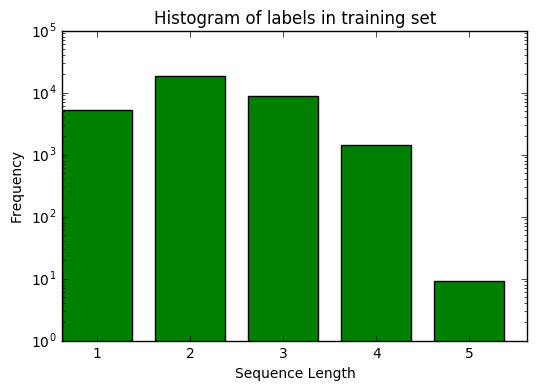

In [13]:
# plot histogram of labels in train set
ind = np.array([1,2,3,4,5] )   # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, tr_freqs_l[1:6], 0.75, color='g')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of labels in training set')
plt.xticks(ind + width/2., ('1', '2', '3', '4', '5'))
plt.yscale('log')
plt.show()

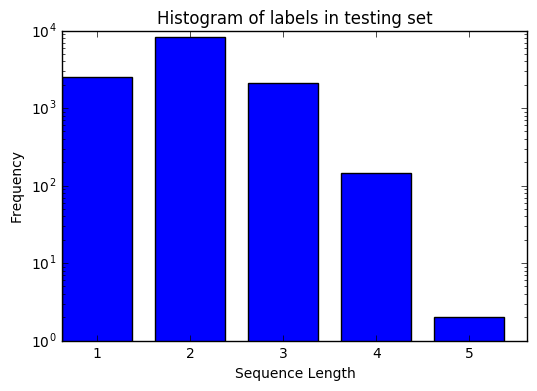

In [14]:
# plot histogram of labels in test set
ind = np.array([1,2,3,4,5] )   # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, te_freqs_l[1:6], 0.75, color='b')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of labels in testing set')
plt.xticks(ind + width/2., ('1', '2', '3', '4', '5'))
plt.yscale('log')
plt.show()

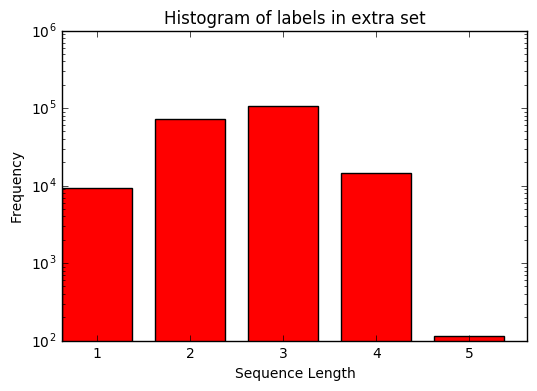

In [15]:
# plot histogram of labels in extra set
ind = np.array([1,2,3,4,5] )   # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, ex_freqs_l[1:6], 0.75, color='r')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of labels in extra set')
plt.xticks(ind + width/2., ('1', '2', '3', '4', '5'))
plt.yscale('log')
plt.show()

In [16]:
# frequencies of lengths in extra+train dataset
ex_freqs_l[1:6]+tr_freqs_l[1:6]

array([ 14522,  89856, 115480,  15772,    124])

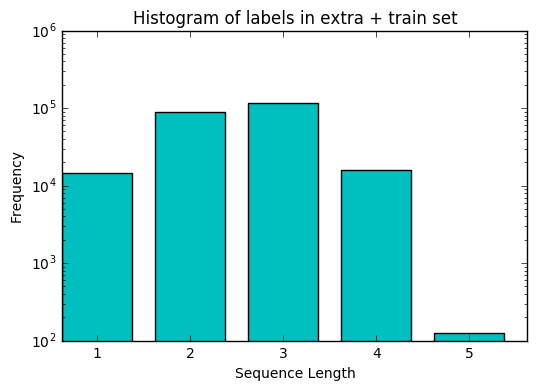

In [17]:
# plot histogram of labels in train+extra set
ind = np.array([1,2,3,4,5] )   # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, ex_freqs_l[1:6]+tr_freqs_l[1:6], 0.75, color='c')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of labels in extra + train set')
plt.xticks(ind + width/2., ('1', '2', '3', '4', '5'))
plt.yscale('log')
plt.show()

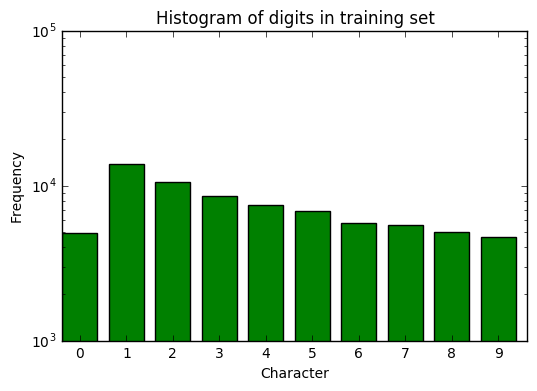

In [18]:
# plot histogram of characters in train set
ind = np.array([0,1,2,3,4,5,6,7,8,9])   # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, tr_freqs_d, 0.75, color='g')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.title('Histogram of digits in training set')
plt.xticks(ind + width/2., ('0','1', '2', '3', '4', '5','6','7','8','9'))
plt.yscale('log')
plt.show()

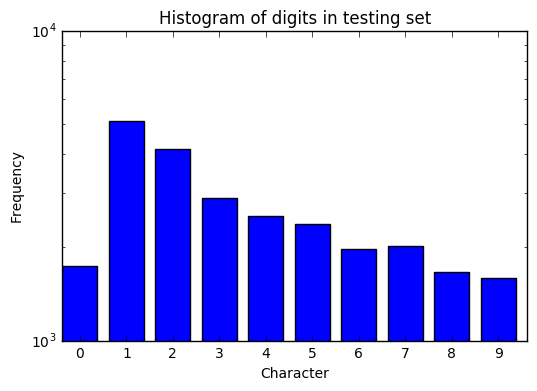

In [19]:
# plot histogram of characters in test set
ind = np.array([0,1,2,3,4,5,6,7,8,9])   # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, te_freqs_d, 0.75, color='b')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.title('Histogram of digits in testing set')
plt.xticks(ind + width/2., ('0','1', '2', '3', '4', '5','6','7','8','9'))
plt.yscale('log')
plt.show()

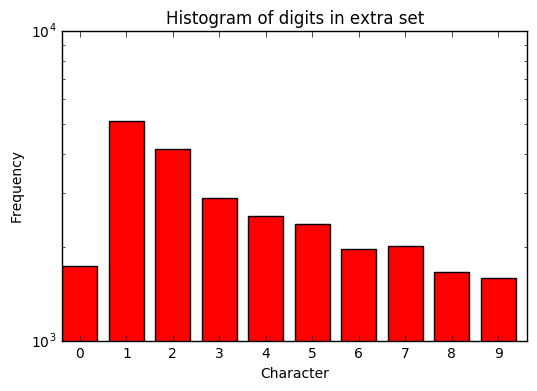

In [20]:
# plot histogram of characters in extra set
ind = np.array([0,1,2,3,4,5,6,7,8,9])   # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, te_freqs_d, 0.75, color='r')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.title('Histogram of digits in extra set')
plt.xticks(ind + width/2., ('0','1', '2', '3', '4', '5','6','7','8','9'))
plt.yscale('log')
plt.show()

In [21]:
# get few random indexes from extra images dictionary
arr = np.arange(len(extra_dict.keys()))
np.random.shuffle(arr)
my_arr=arr[0:10]
print(my_arr)

[ 38339  32407 131283  96562  43770   6548  15697  51979 184181  11492]


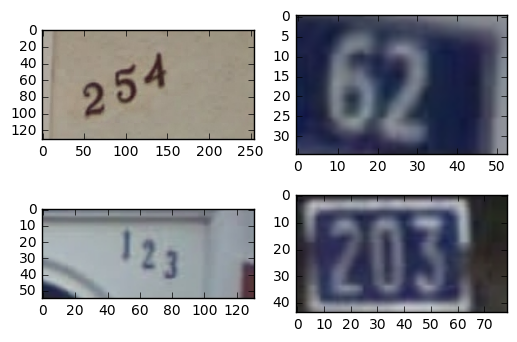

In [22]:
# plot earlier selected indexes
for my_idx in range(len(my_arr)):
    filename=str(my_arr[my_idx])+'.png'
    fpath=os.path.join('extra', filename)
    my_img=Image.open(fpath)
    
    #plt.subplot(my_idx/3+1, 1, my_idx+1)
    plt.subplot(221+my_idx/3)
    imgplot=plt.imshow(my_img,cmap='Greys_r')
    #print(fpath)
    #time.sleep(1)
plt.show()

In [23]:
# function that creates dataset/labels from the images dictionary
# the dataset has 1 output channel
# processess images with character lengths <=5

img_size=32
def get_my_dataset(mystruct, dir_name):
    mykeys = mystruct.keys()
    mykeys.sort()
    dataset = np.ndarray([len(mykeys),img_size,img_size,1],dtype='float32')
    labels = np.ones([len(mykeys),6], dtype=int) * 10

    #for k in mykeys:
    for idx in range(len(mykeys)):
        k=mykeys[idx]
        tmpdict=mystruct[k]
        #print(tmpdict)

        filename=tmpdict['name']
        label_list=tmpdict['label']

        #process image if label_length is <= 5
        if len(label_list)<=5:
            #populate labels
            for jdx in range(len(label_list)):
                labels[idx,jdx+1]=label_list[jdx]
            labels[idx,0]=len(label_list)
            
            #populate dataset
            fpath=os.path.join(dir_name, filename)#dpath+filename
            fpng=Image.open(fpath)
            #fpng=fpng.convert('L')
            fpng_crop=fpng.crop((tmpdict['left'],tmpdict['top'],tmpdict['right'],tmpdict['bottom']))
            fpng_resized = fpng_crop.resize((img_size,img_size),Image.BICUBIC)
            fpng_data=np.array(fpng_resized, dtype='float32')
            fpng_data = np.dot(np.array(fpng_data, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
            fpng_mean=np.mean(fpng_data, dtype='float32')
            fpng_std = np.std(fpng_data, dtype='float32', ddof=1)
            if fpng_std < 1e-4:
               fpng_std=1.0
            fpng_data=(fpng_data-fpng_mean)/fpng_std
            dataset[idx,:,:]=fpng_data[:,:]
        else:
            #print info about images with label_length >5
            print(tmpdict)

        #debug: print and save this image
        #if k =='5.png':
        #    print (k)        
        #    print(tmpdict)
            #print(fpng_data)
            #fpng_resized.save('result.png')

        #print(k)
        #print(labels)


    return dataset, labels

In [24]:
# function that creates dataset/labels from the images dictionary
# the dataset has 3 output channels
# processess images with character lengths <=5

img_size=32
def get_my_color_dataset(mystruct, dir_name):
    mykeys = mystruct.keys()
    mykeys.sort()
    dataset = np.ndarray([len(mykeys),img_size,img_size,3],dtype='float32')
    labels = np.ones([len(mykeys),6], dtype=int) * 10

    #for k in mykeys:
    for idx in range(len(mykeys)):
        k=mykeys[idx]
        tmpdict=mystruct[k]
        #print(tmpdict)

        filename=tmpdict['name']
        label_list=tmpdict['label']

        #process image if label_length is <= 5
        if len(label_list)<=5:
            #populate labels
            for jdx in range(len(label_list)):
                labels[idx,jdx+1]=label_list[jdx]
            labels[idx,0]=len(label_list)
            
            #populate dataset
            fpath=os.path.join(dir_name, filename)#dpath+filename
            fpng=Image.open(fpath)
            #fpng=fpng.convert('L')
            fpng_crop=fpng.crop((tmpdict['left'],tmpdict['top'],tmpdict['right'],tmpdict['bottom']))
            fpng_resized = fpng_crop.resize((img_size,img_size),Image.BICUBIC)
            fpng_data=np.array(fpng_resized, dtype='float32')
            #fpng_data = np.dot(np.array(fpng_data, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
            fpng_mean=np.mean(fpng_data, dtype='float32')
            fpng_std = np.std(fpng_data, dtype='float32', ddof=1)
            if fpng_std < 1e-4:
               fpng_std=1.0
            fpng_data=(fpng_data-fpng_mean)/fpng_std
            dataset[idx,:,:]=fpng_data[:,:]
        else:
            #print info about images with label_length >5
            print(tmpdict)

        #debug: print and save this image
        #if k =='5.png':
        #    print (k)        
        #    print(tmpdict)
            #print(fpng_data)
            #fpng_resized.save('result.png')

        #print(k)
        #print(labels)


    return dataset, labels

In [25]:
# DEBUG CODE: can be ignored
# code to remove key from python dictionary
temp_diction={}
temp_diction['abc']=1
temp_diction['cde']=2
temp_diction['fgh']=3
print(temp_diction)
del temp_diction['cde']
print(temp_diction)

{'cde': 2, 'abc': 1, 'fgh': 3}
{'abc': 1, 'fgh': 3}


In [26]:
# print list of outlier images (length=6) in the train dataset
print(tr_outliers)

['29930.png']


In [27]:
# remove outlier from train dataset
print('length of train dataset before delete: ',len(train_dict.keys()))
del train_dict['29930.png']
print('length of train dataset after delete: ',len(train_dict.keys()))

length of train dataset before delete:  33402
length of train dataset after delete:  33401


In [28]:
# create datasets
train_my_dataset, train_my_labels = get_my_color_dataset(train_dict, train_dir)
test_my_dataset, test_my_labels = get_my_color_dataset(test_dict, test_dir)
extra_my_dataset, extra_my_labels = get_my_color_dataset(extra_dict, extra_dir)

In [29]:
# print dimensions of datasets
print(train_my_dataset.shape, train_my_labels.shape)
print(test_my_dataset.shape, test_my_labels.shape)
print(extra_my_dataset.shape, extra_my_labels.shape)

(33401, 32, 32, 3) (33401, 6)
(13068, 32, 32, 3) (13068, 6)
(202353, 32, 32, 3) (202353, 6)


In [30]:
# print details of first image (train dataset)
print(train_dict['1.png'])
print(train_my_labels[0])

{'right': 419, 'name': '1.png', 'bottom': 300, 'top': 77, 'label': [1, 9], 'height': 219, 'width': 81, 'len_label': 2, 'left': 246}
[ 2  1  9 10 10 10]


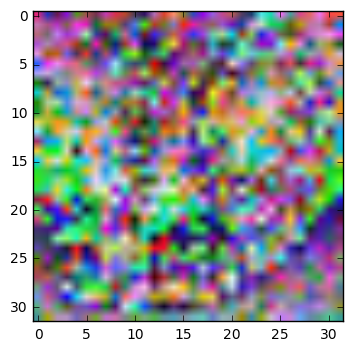

In [31]:
# plot first image (from train datset)
img_test=train_my_dataset[0]
imgplot = plt.imshow(img_test)

In [32]:
# define a function to get number of pixels in the images dictionary
def get_image_info(mydict):
    pixels_list=[]
    for ikey in mydict.keys():
        tmp_dict=mydict[ikey]
        pixels_list.append(tmp_dict['width']*tmp_dict['height'])

    return pixels_list

train_pixels_list = get_image_info(train_dict)
test_pixels_list = get_image_info(test_dict)
extra_pixels_list = get_image_info(extra_dict)

print(len(train_pixels_list),len(test_pixels_list),len(extra_pixels_list))

33401 13068 202353


In [33]:
print(min(train_pixels_list), max(train_pixels_list))
print(min(test_pixels_list),  max(test_pixels_list))
print(min(extra_pixels_list), max(extra_pixels_list))

11 83018
33 25376
17 49868


In [34]:
# DEBUG CODE: can be ignored
# print images from train set with width=1
for ikey in train_dict.keys():
    tmp_dict=train_dict[ikey]
    #k=mykeys[idx]
    #tmpdict=mystruct[k]
    if tmp_dict['width']==1:
        print (tmp_dict)
    if tmp_dict['height']<=3:
        print (tmp_dict)


{'right': 50, 'name': '29586.png', 'bottom': 31, 'top': 1, 'label': [1, 4, 4], 'height': 29, 'width': 1, 'len_label': 3, 'left': 26}
{'right': 61, 'name': '18702.png', 'bottom': 35, 'top': 6, 'label': [5, 2, 4], 'height': 11, 'width': 1, 'len_label': 3, 'left': 33}


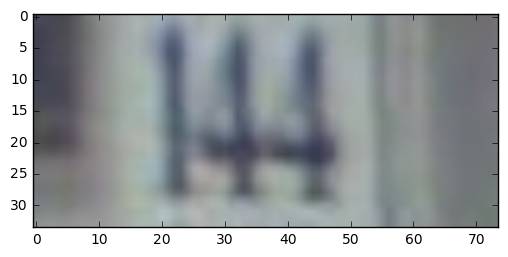

In [35]:
# DEBUG CODE: can be ignored
# print 1st odd image
odd_img='29586.png'
fpath=os.path.join('train', odd_img)
my_img=Image.open(fpath)

import matplotlib.pyplot as plt
%matplotlib inline
imgplot=plt.imshow(my_img,cmap='Greys_r')

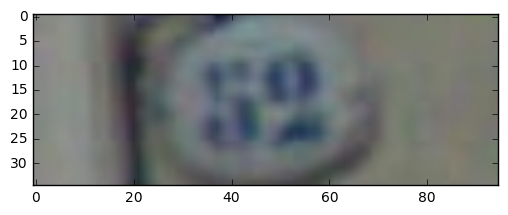

In [36]:
# DEBUG CODE: can be ignored
# print 2nd odd image
odd_img='18702.png'
fpath=os.path.join('train', odd_img)
my_img=Image.open(fpath)

import matplotlib.pyplot as plt
%matplotlib inline
imgplot=plt.imshow(my_img,cmap='Greys_r')

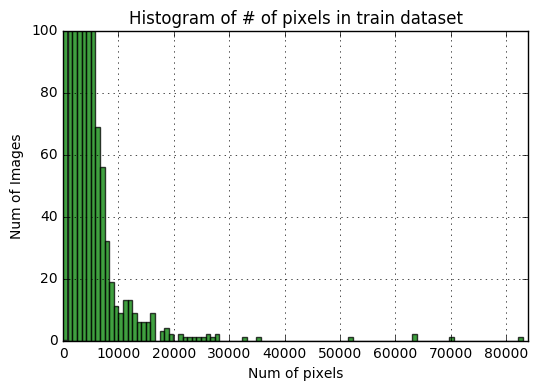

In [37]:
# plot histogram of number of pixels in the train data
n, bins, patches = plt.hist(train_pixels_list, 100, normed=0, facecolor='g', alpha=0.75)


plt.xlabel('Num of pixels')
plt.ylabel('Num of Images')
plt.title('Histogram of # of pixels in train dataset')
plt.axis([0, 84000, 0, 100])
plt.grid(True)
#plt.yscale('log')
plt.show()

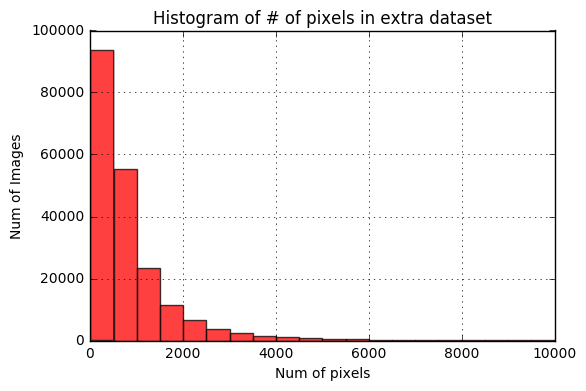

In [38]:
# plot histogram of number of pixels in the extra data
n, bins, patches = plt.hist(extra_pixels_list, 100, normed=0, facecolor='r', alpha=0.75)


plt.xlabel('Num of pixels')
plt.ylabel('Num of Images')
plt.title('Histogram of # of pixels in extra dataset')
plt.axis([0, 10000, 0, 100000])
plt.grid(True)
#plt.yscale('log')
plt.show()

In [39]:
# merge train and extra datasets into one
all_my_dataset=np.concatenate((train_my_dataset[:,:,:,:],extra_my_dataset[:,:,:,:]),axis=0)
all_my_labels=np.concatenate((train_my_labels[:,:],extra_my_labels[:,:]),axis=0)

In [40]:
# remove extra and train datasets/labels to free up memory
del train_my_dataset
del train_my_labels
del extra_my_dataset
del extra_my_labels

In [41]:
# prep for creating validation and train datasets from themerged dataset
# shuffle index from merge datasets
# assign 1st 6000 to validation dataset/labels
# assign rest to train dataset/labels
len_all=len(all_my_labels)
shuffle_all = np.arange(len_all)
np.random.shuffle(shuffle_all)
valid_index=shuffle_all[0:6000]
train_index=shuffle_all[6000:]

In [42]:
# create validation and train datasets from merged dataset/labels
valid_dataset = all_my_dataset[valid_index,:,:,:]
valid_labels = all_my_labels[valid_index,:]
train_dataset_t = all_my_dataset[train_index,:,:,:]
train_labels_t = all_my_labels[train_index,:]

print(train_dataset_t.shape, train_labels_t.shape)
print(test_my_dataset.shape, test_my_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(229754, 32, 32, 3) (229754, 6)
(13068, 32, 32, 3) (13068, 6)
(6000, 32, 32, 3) (6000, 6)


In [43]:
# remove merged dataset/labels to free up memory
del all_my_dataset
del all_my_labels

In [44]:
# pickle test, train,validation data to different files as they are big

pickle_file_test = 'svhn_my_all_color_test.pickle'
try:
  f = open(pickle_file_test, 'wb')
  save = {
    'test_dataset': test_my_dataset,
    'test_labels': test_my_labels
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file_test, ':', e)
  raise
    
statinfo = os.stat(pickle_file_test)
print('Compressed pickle size:', statinfo.st_size)

pickle_file_valid = 'svhn_my_all_color_valid.pickle'

try:
  f = open(pickle_file_valid, 'wb')
  save = {
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file_valid, ':', e)
  raise
    
statinfo = os.stat(pickle_file_valid)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 161207092
Compressed pickle size: 74016246


In [45]:
# remove pickled datasets/labels to free up memory
del test_my_dataset
del test_my_labels
del valid_dataset
del valid_labels

In [47]:
# pickle train data

pickle_file_train = 'svhn_my_all_color_train.pickle'
try:
  f = open(pickle_file_train, 'wb')
  save = {
    'train_dataset': train_dataset_t,
    'train_labels': train_labels_t
    }
  pickle.dump(save, f, 0)#pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file_train, ':', e)
  raise
    
statinfo = os.stat(pickle_file_train)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 7933430211


In [ ]:
pickle_file = 'svhn_my_all_color.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_t,
    'train_labels': train_labels_t,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_my_dataset,
    'test_labels': test_my_labels
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

In [274]:
# DEBUG CODE: can be ignored
mytmp=[1,2,3,4,5,6]
print(mytmp[0:3])
print(mytmp[3:6])

[1, 2, 3]
[4, 5, 6]


In [267]:
# DEBUG CODE: can be ignored
tmp1=train_my_labels[0:5,:]
tmp2=train_my_labels[5:10,:]
tmp3=np.concatenate((tmp1,tmp2),axis=0)
tmp3

array([[ 2,  1,  9, 10, 10, 10],
       [ 2,  1,  6, 10, 10, 10],
       [ 3,  1,  0,  9, 10, 10],
       [ 2,  1,  3, 10, 10, 10],
       [ 3,  1,  5,  3, 10, 10],
       [ 2,  4,  1, 10, 10, 10],
       [ 3,  2,  1,  0, 10, 10],
       [ 2,  5,  9, 10, 10, 10],
       [ 2,  8,  8, 10, 10, 10],
       [ 4,  1,  0,  0,  0, 10]])

In [14]:
# DEBUG CODE: can be ignored
filename = 'digitStruct.csv'
fullpath = os.path.join('train_30', filename)
print(fullpath)

train_30/digitStruct.csv
